In [1]:
#This notebook is designed to be converted to a HTML slide show
#To do this in the command prompt type (in the folder containing the notebook): 
#       jupyter nbconvert *.ipynb --to slides

# Stochastics and Bioscrape Lineages
## William Poole
## SB-tools Bootcamp 06-23-2020
__Overview:__ In this workshop, we will discuss deterministic versus stochastic semantics of Chemical Reaction Networks and briefly review some of the intricacies when working with stochastic simulation data.

## What is a CRN?
A CRN is a widely established model of chemistry and biochemistry.
* A set of species $S$
* A set of reactions $R$ interconvert species $I_r$ to $O_r$

\begin{align}
\\
I \xrightarrow[]{\rho(s)} O
\\
\end{align}

 * $I$ and $O$ are multisets of species $S$. 
 * $\rho(s): S \to \mathbb{R}$ is a function that determines how fast the reaction occurs.



### Example
\begin{equation}
\emptyset  \underset{1}{\overset{100}\rightleftharpoons}  2 A
\end{equation}

/Users/ankitaroychoudhury/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following species are uninitialized and their value has been defaulted to 0: A, 
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Deterministic Trajectory: $\\emptyset \\leftrightarrow 2A$')

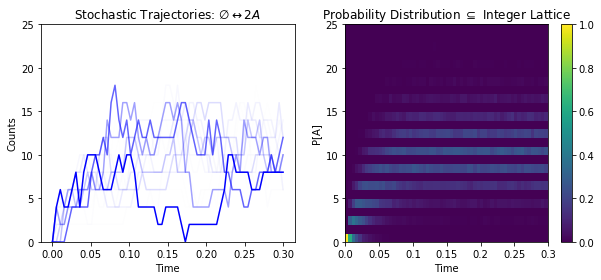

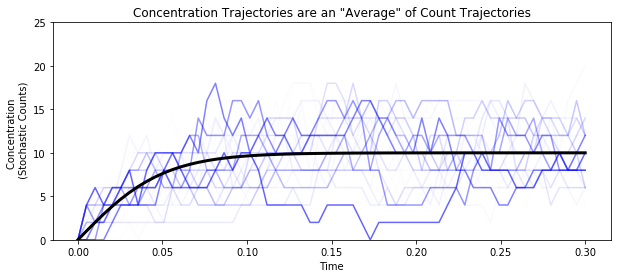

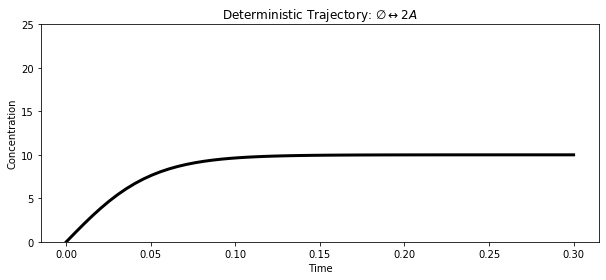

In [2]:
#Plot the example - code not shown in lecture
#Using Bioscrape: Basic Imports
from bioscrape.types import Model
from bioscrape.simulator import py_simulate_model
#For arrays and plotting
import numpy as np
import pylab as plt

#Create a CRN
CRN = Model(species = ["A"], reactions = [([], ["A", "A"], "massaction", {"k":100}), (["A", "A"], [], "massaction", {"k":1})])


T = 60 #Number of time-points
N = 500 #Number of Simulations
tmax = .3 #Max time
timepoints = np.linspace(0, tmax, T)
HM = np.zeros((T, 25)) #Heatmap for storing the probability distirbution P[t, A]

#Create axes
plt.figure("fig stoch", figsize = (10, 4))
ax1 = plt.subplot(121)
#Run N simulations
for i in range(N):
    #Simulate model stochastically
    R = py_simulate_model(timepoints = timepoints, Model = CRN, stochastic = True)
    
    #Add to HM dist
    for t in range(T):
        if R["A"][t] < 25: #Truncate if the value is out of the heatmap (very rare)
            HM[t, int(R["A"][t])]+=1/N #Renomralize per simulation
    plt.sca(ax1)
    plt.plot(timepoints, R["A"], color = (0, i/N, 1-i/N), alpha = np.exp(-i/2))

    plt.figure("fig det and stoch", figsize = (10, 4))
    plt.plot(timepoints, R["A"], color = (0, i/N, 1-i/N), alpha = .6*np.exp(-i/5))

plt.figure("fig stoch")
plt.title("Stochastic Trajectories: $\emptyset \leftrightarrow 2A$")
plt.xlabel("Time")
plt.ylabel("Counts")
plt.ylim(0, 25)
plt.subplot(122)
plt.title("Probability Distribution $\subseteq$ Integer Lattice")
cb = plt.pcolor(HM.T)
plt.colorbar(cb)
plt.xlabel("Time")
plt.ylabel("P[A]")
plt.xticks([10*i for i in range(int(T/10)+1)], [str(round(i/T*tmax*10, 3)) for i in range(int(T/10)+1)])

plt.figure("fig det and stoch")
R = py_simulate_model(timepoints = timepoints, Model = CRN, stochastic = False) #Deterministic Simulation
plt.plot(timepoints, R["A"], color = 'black', lw = 3)
plt.title('Concentration Trajectories are an "Average" of Count Trajectories')
plt.xlabel("Time")
plt.ylabel("Concentration \n (Stochastic Counts)")
plt.ylim(0, 25)

plt.figure("fig det", figsize = (10, 4))
plt.plot(timepoints, R["A"], color = 'black', lw = 3)
plt.xlabel("Time")
plt.ylim(0, 25)
plt.ylabel("Concentration")
plt.title("Deterministic Trajectory: $\emptyset \leftrightarrow 2A$")

# CRNs Can be interpreted deterministically

**Deterministic Semantics** considers the concentrations of molecules modelled as an ordinary differential equation (ODE):

\begin{equation}
\frac{d[S]}{dt} = \sum_r \Delta_r \rho_r([S])
\end{equation}

### Example:
\begin{equation}
\emptyset  \underset{1}{\overset{100}\rightleftharpoons}  2 A \quad \Rightarrow \quad 
\frac{d[A]}{dt} = 100-1[A]^2 
\end{equation}

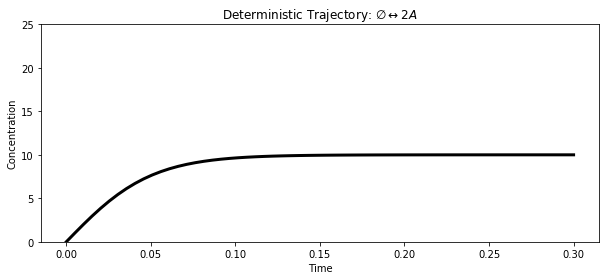

# CRNs can be interpreted stochastically

**Stochastic Semantics** considers the probability of counts of molecules:


\begin{align}
\frac{d \mathbb{P}[s, t]}{dt} = \sum_r \mathbb{P}[s + \Delta_r, t] \rho_r(s + \Delta_r) - \mathbb{P}[s, t]\rho_r(s)
\end{align}

* This equation is the chemical master equation and can be simulated via the [Gillespie Algorithm](http://cctbio.ece.umn.edu/wiki/images/7/78/Gillespie-Daniel-T_Stochastic_Simulation_of_Chemical_Kinetics.pdf) as a Markov jump process
* $s_i = \textrm{count} (S_i)$
* $\Delta_r = O_r - I_r$ is the stochiometric matrix



### Example:
\begin{equation}
\emptyset  \underset{1}{\overset{100}\rightleftharpoons}  2 A \quad \Rightarrow \quad
\frac{\partial}{\partial t}
\begin{vmatrix}
    \mathbb{P}[A=0, t]\\
    \mathbb{P}[A=1, t]\\
    \mathbb{P}[A=2, t]\\
    ...\\
    \mathbb{P}[A=s, t] \\
    ...
\end{vmatrix} =
\begin{vmatrix} 
    -\mathbb{P}[A=2, t] \\
    -\mathbb{P}[A=3, t] \\
    100 \mathbb{P}[A=0, t] - \mathbb{P}[A=4, t] \\
    ...\\
    100 \mathbb{P}[A=s-2, t] - \mathbb{P}[A=s+2, t] \\
    ... \\
\end{vmatrix} 
\quad \Rightarrow \quad
\frac{\partial \mathbb{P}_t}{\partial t} = Q \mathbb{P}_t
\end{equation}
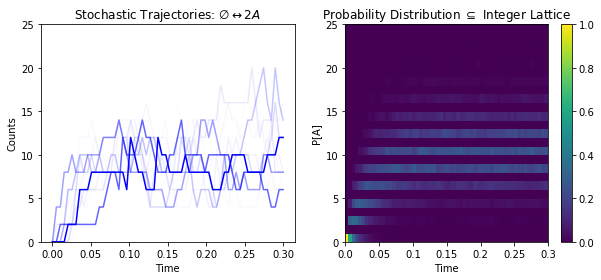

## Deterministic Semantics is a limit of Stochasic Semantics

\begin{equation}
\lim_{s_i, V \to \infty} \mathbb{P}_t[s] \textrm{ s.t. } \frac{s_i}{V} = [S_i]
\end{equation}

* This limit is subtle and is not the same as the expected value.

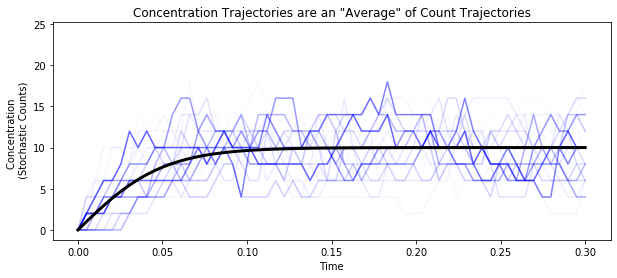

* Deterministic "Steady States" correspond to stochastic "Steady State Distributions".


# When to use stochastic simulation versus deterministic?

### Stochastic:
* Small Copy number of molecules ($n<20$)
* Investigating noise and variance
* Single cell data (microscopy, flow cytometry)

### Deterministic:
* Large copy number ($n>100$)
* Investigating bulk or average behavior (plate reader data, populations of cells)
* When analytic and/or numerical tractability are important



# A Model of Signalling
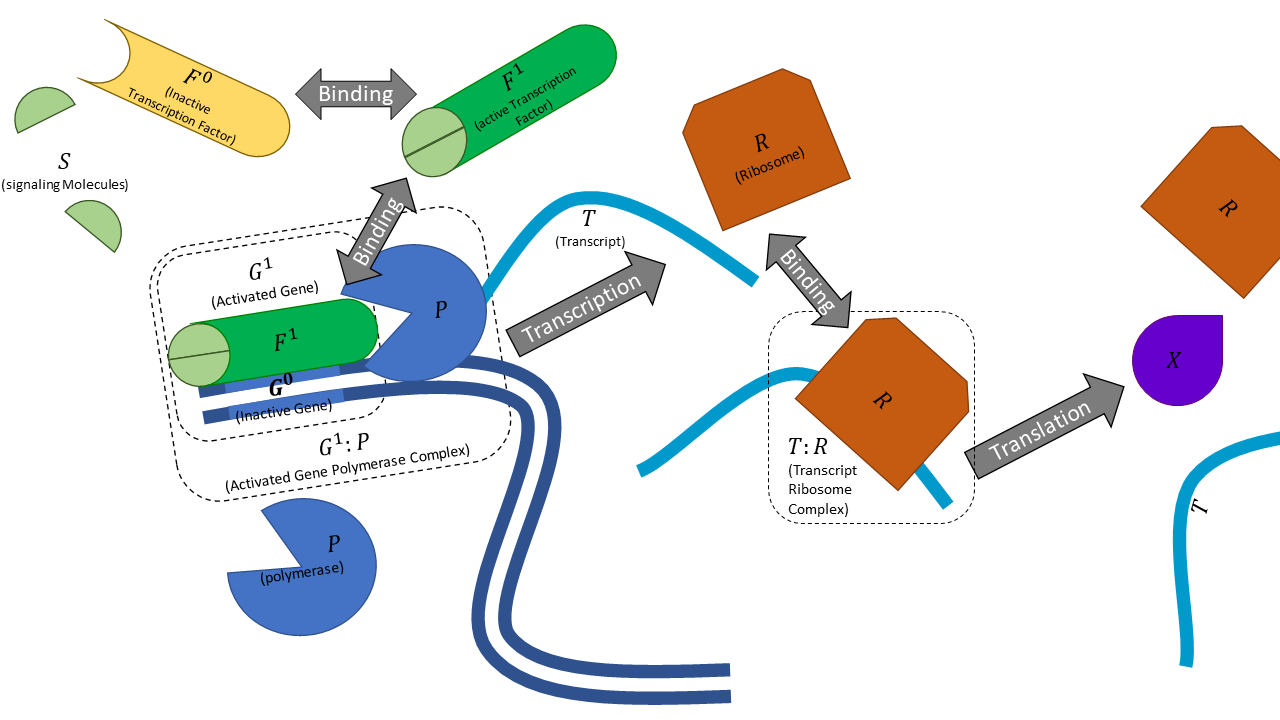

In [3]:
from biocrnpyler import *

#Create Species for this model
S = Species("S")
F0 = Species("F0")
F1 = ComplexSpecies([S, S, F0])
G0 = Species("G0")
G1 = ComplexSpecies([F1, G0])
P = Species("P")
G1P = ComplexSpecies([G1, P])
T = Species("T")
Ri = Species("R")
TR = ComplexSpecies([T, Ri])
X = Species("X")
species = [S, F0, F1, G0, G1, P, G1P, T, Ri, TR, X]

In [4]:
#Create Reactions for this model
ku = 10
kb = 100
ktx = .8
ktl = 5
kdil = .5
rxn1 = Reaction([S, S, F0], [F1], k = kb, k_rev = ku) #2S + F0 <--> F1
rxn2 = Reaction([F1, G0], [G1], k = kb, k_rev = ku) #F1 + G0 <--> G1
rxn3 = Reaction([G1, P], [G1P], k = kb, k_rev = ku) #G1 + P <--> G1P
rxn4 = Reaction([T, Ri], [TR], k = kb, k_rev = ku) #T + R <--> TR
rxntx = Reaction([G1P], [G1, P, T], k = ktx) #Transcription
rxntl = Reaction([TR], [T, Ri, X], k = ktx) #Transcription
rxndt = Reaction([T], [], k = kdil) #T-->0
rxndx = Reaction([X], [], k = kdil) #X-->0
rxnds = Reaction([S], [], k = kdil) #S-->0
reactions = [rxn1, rxn2, rxn3, rxn4, rxntx, rxntl, rxndt, rxndx, rxnds]

In [5]:
CRN = ChemicalReactionNetwork(species = species, reactions = reactions)
print(CRN.pretty_print())

Species (11) = {0. S, 1. F0, 2. complex[F0:2x_S], 3. G0, 4. complex[G0:complex[F0:2x_S]], 5. P, 6. complex[P:complex[G0:complex[F0:2x_S]]], 7. T, 8. R, 9. complex[R:T], 10. X}
Reactions (9) = [
0. 2 S + F0 <--> complex[F0:2x_S]        
        massaction: k_f(S,F0)=100*S^2*F0
        k_r(complex[F0:2x_S])=10*complex[F0:2x_S]
1. complex[F0:2x_S] + G0 <--> complex[G0:complex[F0:2x_S]]        
        massaction: k_f(complex[F0:2x_S],G0)=100*complex[F0:2x_S]*G0
        k_r(complex[G0:complex[F0:2x_S]])=10*complex[G0:complex[F0:2x_S]]
2. complex[G0:complex[F0:2x_S]] + P <--> complex[P:complex[G0:complex[F0:2x_S]]]        
        massaction: k_f(complex[G0:complex[F0:2x_S]],P)=100*complex[G0:complex[F0:2x_S]]*P
        k_r(complex[P:complex[G0:complex[F0:2x_S]]])=10*complex[P:complex[G0:complex[F0:2x_S]]]
3. T + R <--> complex[R:T]        
        massaction: k_f(T,R)=100*T*R
        k_r(complex[R:T])=10*complex[R:T]
4. complex[P:complex[G0:complex[F0:2x_S]]] --> complex[G0:complex[F0:2x_S

In [6]:
#An initial condition for each species (uninitialized species default to 0)
x0 = {
    str(S):200,
    str(F0):10,
    str(G0):1,
    str(P):25,
    str(Ri):100,
}

In [7]:
#Simulate the Model Deterministically
maxtime = 400
timepoints = np.linspace(0, maxtime, 1000)
Results_det = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0, stochastic = False)

In [8]:
#Toggle Stochastic=True to simulate Stochastically
Results_stoch = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0, stochastic = True)

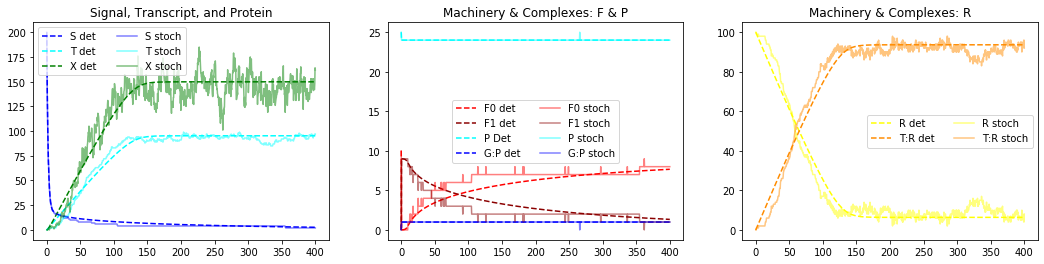

In [9]:
#Plotting
plt.figure(figsize = (18, 4))
plt.subplot(131)
plt.title("Signal, Transcript, and Protein")
plt.plot(timepoints, Results_det[str(S)]+2*Results_det[str(F1)], "--", label = "S det", color = 'blue')
plt.plot(timepoints, Results_det[str(T)]+Results_det[str(TR)], "--", label = "T det", color = 'cyan')
plt.plot(timepoints, Results_det[str(X)], "--", label = "X det", color = 'green')
plt.plot(timepoints, Results_stoch[str(S)]+2*Results_stoch[str(F1)], label = "S stoch", color = 'blue', alpha = .5)
plt.plot(timepoints, Results_stoch[str(T)]+Results_stoch[str(TR)], label = "T stoch", color = 'cyan', alpha = .5)
plt.plot(timepoints, Results_stoch[str(X)], label = "X stoch", color = 'green', alpha = .5)
plt.legend(ncol = 2)

plt.subplot(132)
plt.title("Machinery & Complexes: F & P")
plt.plot(timepoints, Results_det[str(F0)], "--", color = 'red', label = "F0 det")
plt.plot(timepoints, Results_det[str(F1)], "--", color = 'darkred', label = "F1 det")
plt.plot(timepoints, Results_det[str(P)], "--", color = "cyan", label = "P Det")
plt.plot(timepoints, Results_det[str(G1P)], "--", color = "blue", label = "G:P det")

plt.plot(timepoints, Results_stoch[str(F0)], color = 'red', label = "F0 stoch", alpha = .5)
plt.plot(timepoints, Results_stoch[str(F1)], color = 'darkred', label = "F1 stoch", alpha = .5)
plt.plot(timepoints, Results_stoch[str(P)], color = "cyan", label = "P stoch", alpha = .5)
plt.plot(timepoints, Results_stoch[str(G1P)], color = "blue", label = "G:P stoch", alpha = .5)
plt.legend(ncol = 2)

plt.subplot(133)
plt.title("Machinery & Complexes: R")
plt.plot(timepoints, Results_det[str(Ri)], "--", color = "yellow", label = "R det")
plt.plot(timepoints, Results_det[str(TR)], "--", color = "darkorange", label = "T:R det")
plt.plot(timepoints, Results_stoch[str(Ri)], color = "yellow", label = "R stoch", alpha = .5)
plt.plot(timepoints, Results_stoch[str(TR)], color = "darkorange", label = "T:R stoch", alpha = .5)
plt.legend(ncol = 2)

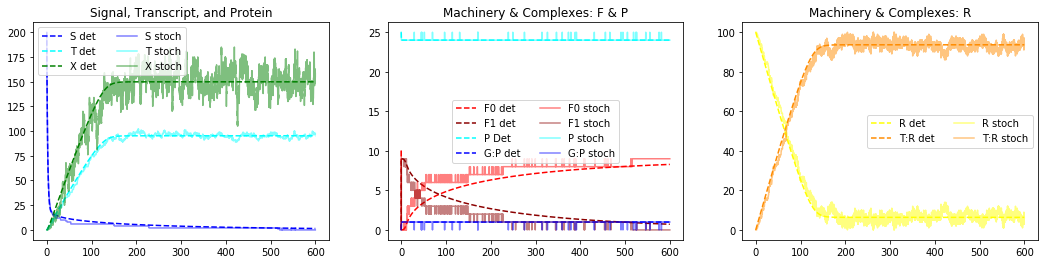


### Small copy number $G_0 = 1$ means more stochasticity
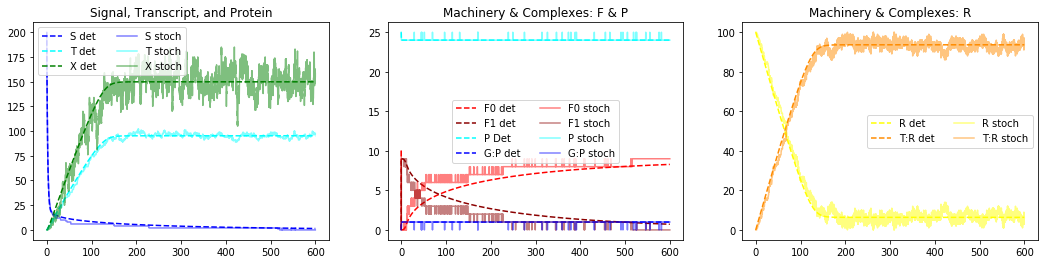

### Larger copy number $G_0 = 10$ means less stochasticity
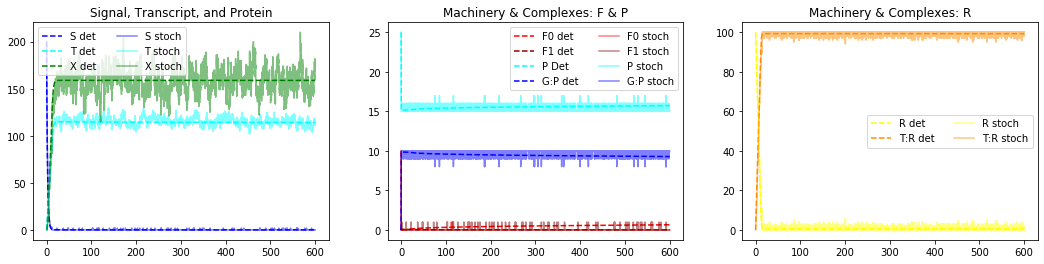

## Analyzing Stochastic Simulations
* Use py_simulate_model(timepoints, model = Model, stochastic = True)
* But now the data is more complex to understand
* Best to think of stochastic trajectories as experiments - you may need multiple samples!

## Collecting Statistics from a single stochastic trajectory

The below example illustrates how important it is to be careful when averaging over a stochastic trajectory. Including the early part of a stochastic simulation in a steady-state average can result in bias due to transient behavior. Not sampling the steady-state "typical set" sufficiently can result in noisy statistics.

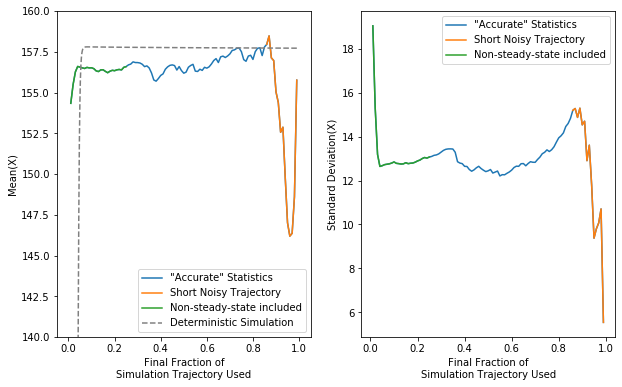

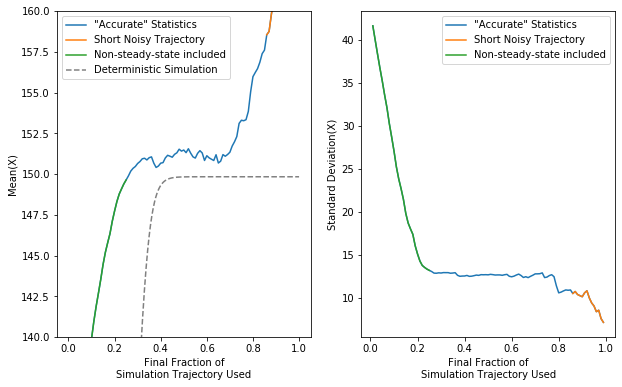

In [10]:
# Burn in and sampling noise in one simulation
#This matters for steady-state statistics
#time dependent statistics require many simulations (see below)

Results_stoch = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0, stochastic = True)

plt.figure(figsize = (10, 6))
plt.subplot(121)
percentages = np.arange(1, 0, -.01) 
plt.plot(percentages,[np.mean(Results_stoch[str(X)][int(t*len(timepoints)):]) for t in percentages], label = '"Accurate" Statistics')
plt.plot(percentages[:15],[np.mean(Results_stoch[str(X)][int(t*len(timepoints)):]) for t in percentages[:15]], label = "Short Noisy Trajectory")
plt.plot(percentages[75:],[np.mean(Results_stoch[str(X)][int(t*len(timepoints)):]) for t in percentages[75:]], label = "Non-steady-state included")
plt.plot(np.linspace(0, 1, len(timepoints)), Results_det[str(X)], "--", color = "grey", label = "Deterministic Simulation")
plt.ylabel("Mean(X)")
plt.xlabel("Final Fraction of\nSimulation Trajectory Used")
plt.legend()
plt.ylim(140, 160)

plt.subplot(122)

plt.plot(percentages,[np.std(Results_stoch["X"][int(t*len(timepoints)):]) for t in percentages], label = '"Accurate" Statistics')
plt.plot(percentages[:15],[np.std(Results_stoch["X"][int(t*len(timepoints)):]) for t in percentages[:15]], label = "Short Noisy Trajectory")
plt.plot(percentages[75:],[np.std(Results_stoch["X"][int(t*len(timepoints)):]) for t in percentages[75:]], label = "Non-steady-state included")
plt.ylabel("Standard Deviation(X)")
plt.xlabel("Final Fraction of\nSimulation Trajectory Used")
plt.legend()

## Collecting Samples from Multiple Stochastic Trajectories
The below example illustrates how multiple stochastic trajectories allow for time-dependent statistics, including transient and steady-state dynamics. There is a computational trade-off between the time spent on individual trajectories and the number of trajectories simulated. For time-dependent statistics, more trajectories may be more important than simulating them longer. For steady-state statistics, fewer longer simulations may be better. That said, these rules of thumb depend on the system of interest and may become very complex in large multi-modal systems.

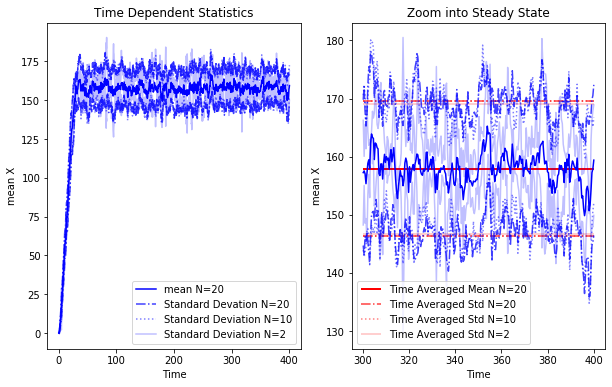

Text(0, 0.5, 'mean X')

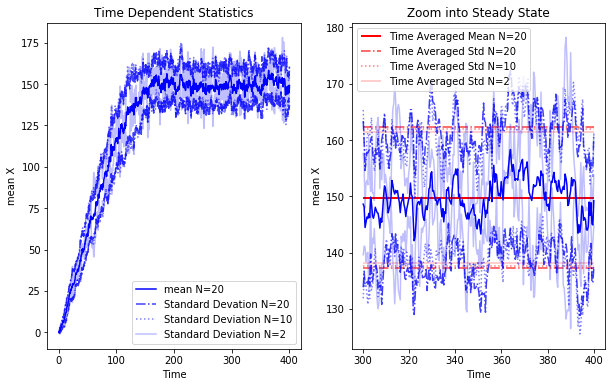

In [11]:
#If we do lots of simulations, we can calculate both better steady state results AND time-dependent statistics

N = 20 #Number of simulations

timepoints = np.linspace(0, maxtime, 1000) #New Timepoints for faster simulations

samples = np.zeros((N, len(timepoints)))
for i in range(N):
    Results_stoch = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0, stochastic = True)
    samples[i, :]= Results_stoch[str(X)]

    
#Calculate Time Dependent Statistics
meanX = np.mean(samples, 0)
std100 = np.std(samples, 0) #100% of samples used to calculate standard deviation
std50 = np.std(samples[:int(N/2), :], 0) #50% of samples
std10 = np.std(samples[:int(N/10), :], 0) #10% of samples

#Calculate Steady State Statistics
ss_start = 750 #Time index to start steady state calculation
meanXss = np.mean(meanX[ss_start:]) #Steady State Mean
std100ss = np.std(samples[:, ss_start:]) #100% of samples used to calculate steady state standard deviation
std50ss = np.std(samples[:int(N/2), ss_start:]) #50% of samples
std10ss = np.std(samples[:int(N/10), ss_start:]) #10% of samples


#Plotting below
plt.figure(figsize = (10, 6))
plt.subplot(121)
plt.title("Time Dependent Statistics")

plt.plot(timepoints, meanX, color = 'blue', label = "mean N="+str(N))
plt.plot(timepoints, meanX+std100,"-.", color = 'blue', alpha = .75, label = "Standard Devation N="+str(N))
plt.plot(timepoints, meanX-std100,"-.", color = 'blue', alpha = .75)
plt.plot(timepoints, meanX+std50,":", color = 'blue', alpha = .5, label = "Standard Deviation N="+str(int(N/2)))
plt.plot(timepoints, meanX-std50,":", color = 'blue', alpha = .5)
plt.plot(timepoints, meanX+std10, color = 'blue', alpha = .25, label = "Standard Deviation N="+str(int(N/10)))
plt.plot(timepoints, meanX-std10, color = 'blue', alpha = .25)

plt.legend()
plt.xlabel("Time")
plt.ylabel("mean X")

plt.subplot(122)
plt.title("Zoom into Steady State")

plt.plot(timepoints[ss_start:], meanX[ss_start:], color = 'blue')
plt.plot(timepoints[ss_start:], meanX[ss_start:]+std100[ss_start:],"-.", color = 'blue', alpha = .75)
plt.plot(timepoints[ss_start:], meanX[ss_start:]-std100[ss_start:],"-.", color = 'blue', alpha = .75)
plt.plot(timepoints[ss_start:], meanX[ss_start:]+std50[ss_start:],":", color = 'blue', alpha = .5)
plt.plot(timepoints[ss_start:], meanX[ss_start:]-std50[ss_start:],":", color = 'blue', alpha = .5)
plt.plot(timepoints[ss_start:], meanX[ss_start:]+std10[ss_start:], color = 'blue', alpha = .25)
plt.plot(timepoints[ss_start:], meanX[ss_start:]-std10[ss_start:], color = 'blue', alpha = .25)

plt.hlines(meanXss, timepoints[ss_start], timepoints[-1], lw = 2, color = 'red', label = "Time Averaged Mean N="+str(N))
plt.hlines(meanXss+std100ss, timepoints[ss_start], timepoints[-1], ls = "-.", alpha = .75, color = 'red', label = "Time Averaged Std N="+str(N))
plt.hlines(meanXss-std100ss, timepoints[ss_start], timepoints[-1], ls = "-.", alpha = .75, color = 'red')
plt.hlines(meanXss+std50ss, timepoints[ss_start], timepoints[-1], ls = ":", alpha = .5, color = 'red', label = "Time Averaged Std N="+str(int(N/2)))
plt.hlines(meanXss-std50ss, timepoints[ss_start], timepoints[-1], ls = ":", alpha = .5, color = 'red')
plt.hlines(meanXss+std10ss, timepoints[ss_start], timepoints[-1], alpha = .25, color = 'red', label = "Time Averaged Std N="+str(int(N/10)))
plt.hlines(meanXss-std10ss, timepoints[ss_start], timepoints[-1], alpha = .25, color = 'red')

plt.legend()
plt.xlabel("Time")
plt.ylabel("mean X")

# Convergence (in both Stochastic and Deterministic Simulation) can be decieving...

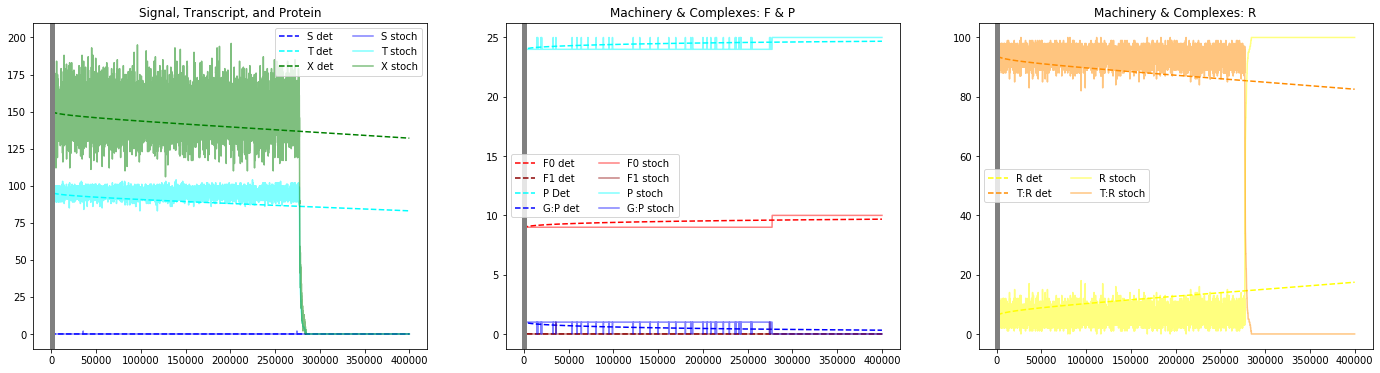

# Lets examine the CRN to figure out how this happened:

In [12]:
print(CRN.pretty_print(show_rates = False))

Species (11) = {0. S, 1. F0, 2. complex[F0:2x_S], 3. G0, 4. complex[G0:complex[F0:2x_S]], 5. P, 6. complex[P:complex[G0:complex[F0:2x_S]]], 7. T, 8. R, 9. complex[R:T], 10. X}
Reactions (9) = [
0. 2 S + F0 <--> complex[F0:2x_S]        
1. complex[F0:2x_S] + G0 <--> complex[G0:complex[F0:2x_S]]        
2. complex[G0:complex[F0:2x_S]] + P <--> complex[P:complex[G0:complex[F0:2x_S]]]        
3. T + R <--> complex[R:T]        
4. complex[P:complex[G0:complex[F0:2x_S]]] --> complex[G0:complex[F0:2x_S]] + P + T        
5. complex[R:T] --> T + R + X        
6. T -->         
7. X -->         
8. S -->         
]


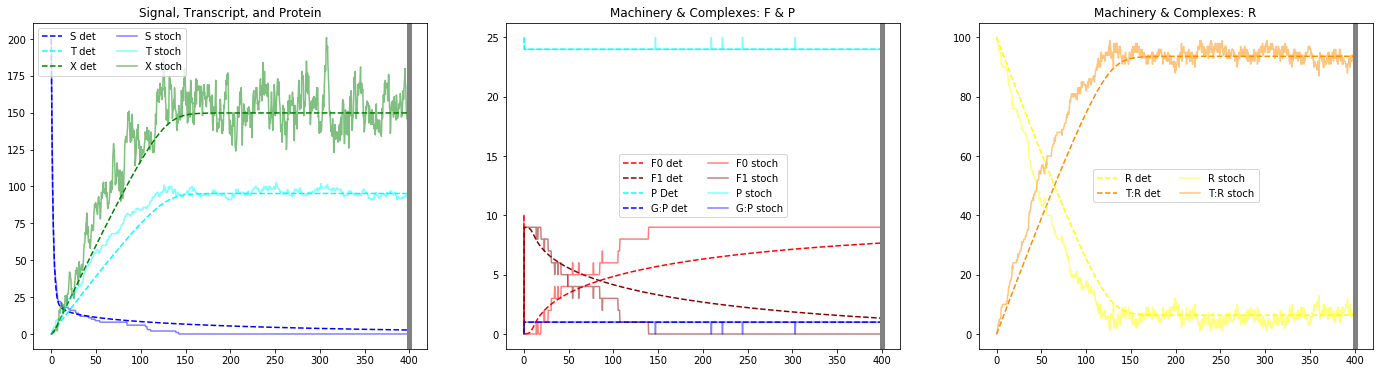

In [13]:
#Run a very long simulation by uncommenting the code below
#This is commented out so the notebook doesn't try to run an incredibly long simulation when openning

#timepoints = np.linspace(0, maxtime*1000, 10000)

#You can also try finding values of the initial conditions so that Stochastic and Deterministic look more similar/different.
#Simulate deterministic versus stochastic
#Original Values: x0 = {"S":200, "F0":10,"G0":1,"P":25,"R":100}
x0 = {
    str(S):200,
    str(F0):10,
    str(G0):1,
    str(P):25,
    str(Ri):100,
}


Results_det = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0, stochastic = False)
Results_stoch = CRN.simulate_with_bioscrape(timepoints, initial_condition_dict = x0, stochastic = True)

#Plotting
plt.figure(figsize = (24, 6))
plt.subplot(131)
plt.title("Signal, Transcript, and Protein")
plt.plot(timepoints, Results_det[str(S)]+2*Results_det[str(F1)], "--", label = "S det", color = 'blue')
plt.plot(timepoints, Results_det[str(T)]+Results_det[str(TR)], "--", label = "T det", color = 'cyan')
plt.plot(timepoints, Results_det[str(X)], "--", label = "X det", color = 'green')
plt.plot(timepoints, Results_stoch[str(S)]+2*Results_stoch[str(F1)], label = "S stoch", color = 'blue', alpha = .5)
plt.plot(timepoints, Results_stoch[str(T)]+Results_stoch[str(TR)], label = "T stoch", color = 'cyan', alpha = .5)
plt.plot(timepoints, Results_stoch[str(X)], label = "X stoch", color = 'green', alpha = .5)
plt.axvline(maxtime, color = "grey", linewidth = 5)
plt.legend(ncol = 2)

plt.subplot(132)
plt.title("Machinery & Complexes: F & P")
plt.plot(timepoints, Results_det[str(F0)], "--", color = 'red', label = "F0 det")
plt.plot(timepoints, Results_det[str(F1)], "--", color = 'darkred', label = "F1 det")
plt.plot(timepoints, Results_det[str(P)], "--", color = "cyan", label = "P Det")
plt.plot(timepoints, Results_det[str(G1P)], "--", color = "blue", label = "G:P det")

plt.plot(timepoints, Results_stoch[str(F0)], color = 'red', label = "F0 stoch", alpha = .5)
plt.plot(timepoints, Results_stoch[str(F1)], color = 'darkred', label = "F1 stoch", alpha = .5)
plt.plot(timepoints, Results_stoch[str(P)], color = "cyan", label = "P stoch", alpha = .5)
plt.plot(timepoints, Results_stoch[str(G1P)], color = "blue", label = "G:P stoch", alpha = .5)
plt.axvline(maxtime, color = "grey", linewidth = 5)

plt.legend(ncol = 2)

plt.subplot(133)
plt.title("Machinery & Complexes: R")
plt.plot(timepoints, Results_det[str(Ri)], "--", color = "yellow", label = "R det")
plt.plot(timepoints, Results_det[str(TR)], "--", color = "darkorange", label = "T:R det")
plt.plot(timepoints, Results_stoch[str(Ri)], color = "yellow", label = "R stoch", alpha = .5)
plt.plot(timepoints, Results_stoch[str(TR)], color = "darkorange", label = "T:R stoch", alpha = .5)
plt.axvline(maxtime, color = "grey", linewidth = 5)

plt.legend(ncol = 2)

### References:
**Simulating Chemical Reaction Networks:**
* [Daniel T. Gillespie. Stochastic Simulation of Chemical Kinetics](http://cctbio.ece.umn.edu/wiki/images/7/78/Gillespie-Daniel-T_Stochastic_Simulation_of_Chemical_Kinetics.pdf). How stochastic CRN simulations work.
* [Swaminathan et al. Fast and flexible simulation and parameter estimation for synthetic biology using bioscrape](https://www.biorxiv.org/content/10.1101/121152v2). The paper introducing Bioscrape.

**Chemical Reaction Networks in Biology**:
* [Domitilla Del Vecchio and Richard M. Murray. Biomolecular Feedback Systems](http://www.cds.caltech.edu/~murray/BFSwiki/index.php/Main_Page). An excellent introduction to biochemical models, simulation, and theory.

**Mathematical Theory of Chemical Reaction Networks**:
* [Jeremy Gunawardena. Chemical reaction network theory for in-silico biologists](http://vcp.med.harvard.edu/papers/crnt.pdf). An introduction into some of the deeper theory of chemical reaction networks with many great references.
* [Soloveichik et al. Computation with finite stochastic chemical reaction networks](https://link.springer.com/article/10.1007/s11047-008-9067-y). Discusses the computational complexity of chemical reactions networks.

**Physics of Chemical Reaction Networks**:
* [Tim Schmiedl and Udo Seifert. Stochastic thermodynamics of chemical reaction networks.](https://aip.scitation.org/doi/full/10.1063/1.2428297). Detailed thermodynamic treatment of stochastic chemical reaction networks.
* [Riccardo Rao and Massimiliano Esposito. Nonequilibrium Thermodynamics of Chemical Reaction Networks:
Wisdom from Stochastic Thermodynamics.](https://arxiv.org/pdf/1602.07257.pdf). A detailed thermodynamic treatment of deterministic chemical reaction networks including many non-equilibrium examples.